# Power Curves

## Background

Recall that **power** of a hypothesis test is the probability that the test correctly rejects the null hypothesis when the alternative hypothesis is in fact true. 

$$Power = Pr(\text{Reject H_0} | \text{H_A is true})$$
,
$$Power = 1 - Pr(\text{Fail to reject H_0} | \text{H_0 is false})$$
, where

$$\beta = Pr(\text{Fail to reject H_0} | \text{H_0 is false})$$

$\beta$ is the probability of committing a Type II error.

$\alpha$, the probability of comitting a Type I error, is given by:

$$\alpha = Pr(\text{Reject H_0} | \text{H_0 is true})$$

Recall that at it's most basic level, **power** is determined by:
- significance level ($\alpha = 0.05$)
- power ($\beta = 0.8$)
- sample size (to be determined as part of experimental design, in our case, buy-in from EPA/States)
- effect size (can be estimated from literature review)

Given any 3 of the above, you can solve for the last. It's also common to generate "power curves". In this case, we can fix $\alpha$ and $\beta$ and generate curves which tell us for a given sample size, what the minimum detectable effect is.

## Power Calculation

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pprint
import rpy2
from rpy2.robjects import IntVector, pandas2ri
from rpy2.robjects.packages import importr
import statsmodels.stats.api as sms

# Importing R Library
psych = importr("psych")

%matplotlib inline

pd.options.display.max_rows = 999
matplotlib.rcParams['figure.figsize'] = [15, 8]

WORKING_DIR = os.path.join(str(pathlib.Path.home()), 'sherlock_epa')
DATA_DIR = os.path.join(WORKING_DIR, 'Data')

# From new analysis independently done with data downloaded 2020-05-03
# https://github.com/reglab/epa_risk/blob/epa-103-dmrnr-eda/eda/dmr_non_receipt.R
DMR_NON_RECEIPT_RATE = 0.066
DELTA = 0.01 # Effect to be estimated from the literature by Anne

es = sms.proportion_effectsize(DMR_NON_RECEIPT_RATE, DMR_NON_RECEIPT_RATE - DELTA)
n = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
print('With a {} baseline DMR Non Receipt SNC Rate, to detect an effect of {}, would require {} facilities in each group'.format(DMR_NON_RECEIPT_RATE, DELTA, round(n)))
      
      

/Users/vincentla/.pyenv/versions/3.7.4/envs/epa-risk/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/Users/vincentla/.pyenv/versions/3.7.4/envs/epa-risk/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


With a 0.066 baseline DMR Non Receipt SNC Rate, to detect an effect of 0.01, would require 8977 facilities in each group


To [reproduce](https://stats.stackexchange.com/questions/83700/why-do-these-power-functions-for-difference-in-proportions-give-different-answer) in R, notice this gives the same result as [pwr::power.2p.test](https://cran.r-project.org/web/packages/pwr/pwr.pdf) in R.

```
> library(pwr)
> p1 = .11
> p2 = 0.1
> h = 2 * asin(sqrt(p1)) - 2 * asin(sqrt(p2))
> pwr.2p.test(h=h, sig.level=0.05, power=0.8)

     Difference of proportion power calculation for binomial distribution (arcsine transformation) 

              h = 0.0326294
              n = 14744.1
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: same sample sizes
```

Note, this is slightly different than `stats::power.prop.test`

```
> library(stats)
> power.prop.test(p1=0.11, p2=0.10, power=0.8, sig.level=0.05, alternative="two.sided")

     Two-sample comparison of proportions power calculation 

              n = 14750.79
             p1 = 0.11
             p2 = 0.1
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group
```

which yields n=14,750. This is due to different in approximation to normal distribution. Overall results are about the same, but could be informative to just go over which assumptions are better?

### Example of Power Curve

#### Power Calculation For Memo

In [2]:
# Deltas to use in memo
deltas_memo = np.linspace(0.01, 0.03, 9)
effect_sizes = []
sample_sizes = []
for dm in deltas_memo:
    es = sms.proportion_effectsize(DMR_NON_RECEIPT_RATE, DMR_NON_RECEIPT_RATE - dm)
    n = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
    effect_sizes.append(es)
    sample_sizes.append(n)
    
df_power = pd.DataFrame({
    'sample_size': sample_sizes,
    'deltas_memo': deltas_memo,
})

print(df_power)
print('Remember that these are sample sizes FOR EACH GROUP')

   sample_size  deltas_memo
0  8976.959982       0.0100
1  5629.251025       0.0125
2  3827.383089       0.0150
3  2750.855098       0.0175
4  2058.534454       0.0200
5  1588.207979       0.0225
6  1254.834035       0.0250
7  1010.386585       0.0275
8   826.104370       0.0300
Remember that these are sample sizes FOR EACH GROUP


#### Holding Alpha and Beta Constant
Below is an example of a "power curve" where alpha and beta are constant. That is, we vary the sample size and then see how the minimum detectable effect varies

In [3]:
deltas = np.linspace(DMR_NON_RECEIPT_RATE / 10, DMR_NON_RECEIPT_RATE / 2, 100)

In [4]:
effect_sizes = []
sample_sizes = []
for d in deltas:
    es = sms.proportion_effectsize(DMR_NON_RECEIPT_RATE, DMR_NON_RECEIPT_RATE - d)
    n = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
    effect_sizes.append(es)
    sample_sizes.append(n)

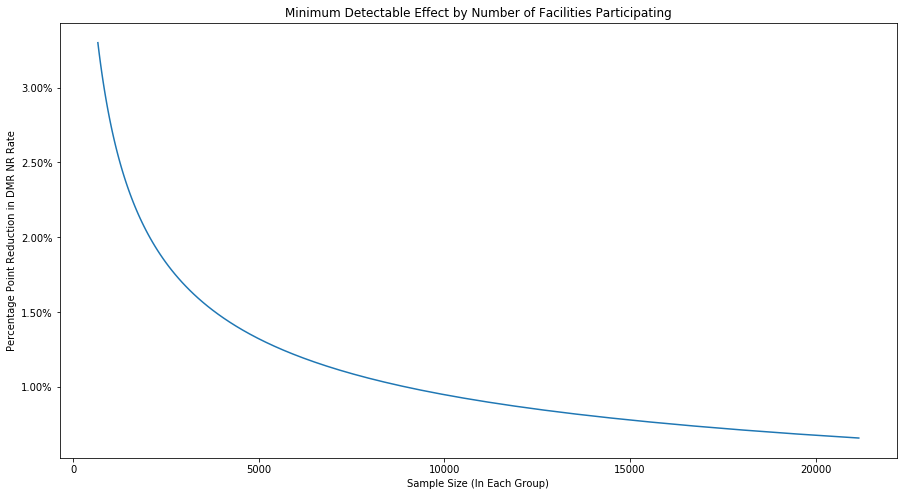

In [5]:
ax = plt.subplot()
ax.plot(sample_sizes, deltas)
plt.ylabel('Percentage Point Reduction in DMR NR Rate')
plt.xlabel('Sample Size (In Each Group)')
plt.title('Minimum Detectable Effect by Number of Facilities Participating')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()

#### Holding Alpha and Effect Size Constant
Below is a different example of a "power curve", this time holding alpha and the effect size constant. This might be a useful interpretation if we ask the question "assume we want to at least detect this effect size, taken from the literature. How many states/facilities do we need to recruit"?

In [6]:
sample_sizes = np.linspace(10, 40000, 1000)
powers = []
for n in sample_sizes:
    es = sms.proportion_effectsize(DMR_NON_RECEIPT_RATE, DMR_NON_RECEIPT_RATE - DELTA)
    power = sms.NormalIndPower().solve_power(es, nobs1=n, power=None, alpha=0.05, ratio=1)
    powers.append(power)

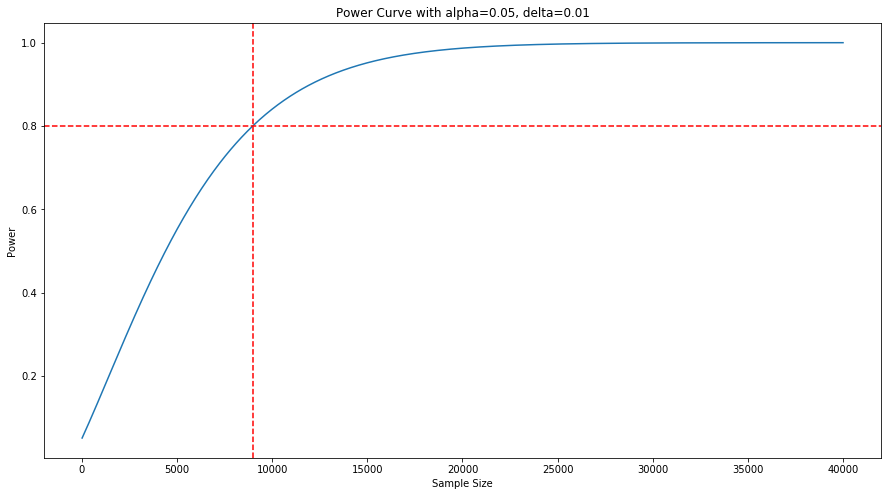

In [7]:
plt.plot(sample_sizes, powers)
plt.ylabel('Power')
plt.xlabel('Sample Size')
plt.axhline(0.8, linestyle='--', color='red')
plt.axvline(sample_sizes[np.argmin(np.abs(np.array(powers) - .8))], linestyle='--', color='red')
plt.title('Power Curve with alpha=0.05, delta=0.01')
plt.show()

In [8]:
print(
"""
The sample size that corresponds to power = 0.8 is {}.

This means we would have to recruit at least this many facilities in each of the control and treatment groups
""".format(sample_sizes[np.argmin(np.abs(np.array(powers) - .8))]))


The sample size that corresponds to power = 0.8 is 8976.726726726727.

This means we would have to recruit at least this many facilities in each of the control and treatment groups



In the graph above, we plot a power curve, with $\alpha = 0.05$ and $\delta = 0.01$. That is, assume a 1 percentage point decrease in the DMR NR Rate in the treatment group. How does power vary with sample size?

## Power Calculation With Multiple Time Periods
See [EPA-120](https://reglab.atlassian.net/browse/EPA-120) for more details

As a simplified way to calculate power if we have multiple time periods, take the current estimated number of observations required in our current power analysis (which assumes 1 time period; as shown in the above section in this notebook) and scale the number of observations up by the Design Effect (DE), where DE is given by:

$$DE = 1 + (n - 1) \rho$$,

where $n$ is the number of observations per cluster and $\rho$ is the Intracluster Correlation Coefficient (ICC). So if we run this out for 2 quarters, $n = 2$ observations per cluster, 3 quarters, $n = 3$ observations per cluster, etc.

Thus,

$$\text{No. of Obs Required} = \text{(No. of Obs Required Assuming 1 Time Period)} * DE$$,
$$\text{Number of Facilities Required} = \text{No. of Obs Required} / \text{No. of Time Periods}$$

So the key thing here is calculating $\rho$, which we can do given historical data.

Note, this is a simplified assumption. Calculating power for clustered designs gets really complicated. See this [memo](https://reg-lab.slack.com/archives/C8JL1LH6W/p1586453488014800) shared by Sandy/Dan for more info. 

At it's core ICC is the between-cluster variability divided by the [sum of the within-cluster and between-cluster variabilities](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1466680/). Put another way, it's the proportion of variance that can be explained by between-cluster variance:

$$\rho = \frac{\sigma_b^2}{\sigma_b^2 + \sigma_w^2}$$,
- $\sigma_b^2$: Between Variance
- $\sigma_w^2$: Within Variance

When the within cluster variance is small, than $\rho \sim 1$, and $DE \sim 1 + (n-1)$ which means the additional observations don't really help us. When the within cluster variance is very large, then $\rho \sim 0$, and thus $DE = 1$ so the additional observations help us fully.

### Calculating ICC

In [9]:
def calculate_icc(data, time_periods):
    """
    Calculate ICC
    
    Keyword Args:
      data: DataFrame of the RNC History By Facility. The key columns you need are NPDES_ID and dmrnr.flag
            Also assumes that you've already subsetted to the time periods necessary and only keep 
            facilities with the same number of observations (so remove any facilities that don't appear in all
            time periods)
      time_periods: Number of Time Periods to consider (so number of observations per facility)
      
    Mostly taken from https://stackoverflow.com/questions/40965579/intraclass-correlation-in-python-module
    """
    values = rpy2.robjects.r.matrix(
        IntVector(data['dmrnr.flag']),
        ncol=time_periods, byrow=True
    )

    try:
        icc = psych.ICC(values)
    except:
        print('Could not calculate ICC for this data')
        return np.nan, np.nan, np.nan
    else:
        # Convert to Pandas DataFrame
        icc_df = pandas2ri.rpy2py(icc[0])

        return icc_df.loc[icc_df.type == 'ICC1']['ICC'],\
               icc_df.loc[icc_df.type == 'ICC2']['ICC'],\
               icc_df.loc[icc_df.type == 'ICC3']['ICC']


In [10]:
def calculate_icc_over_time_periods(data):
    """
    Calculate ICC Over Various Time Periods
    """
    quarters = data['YEARQTR'].unique()
    quarters = np.sort(quarters)
    
    time_period_num_quarters = [2, 3, 4]
    results = {
        2: {
            'icc1': np.array([]),
            'icc2': np.array([]),
            'icc3': np.array([]),
        },
        3: {
            'icc1': np.array([]),
            'icc2': np.array([]),
            'icc3': np.array([]),
        },
        4: {
            'icc1': np.array([]),
            'icc2': np.array([]),
            'icc3': np.array([]),
        },
    }
    
    for q in range(len(time_period_num_quarters)):
        """Iterate over Time Periods"""
        for i in range(len(quarters) - (time_period_num_quarters[q] - 1)):
            """
            Iterate each possible combination

            For example, if the number of quarters is 2, iterate over
              2018Q1 - 2018Q2
              2018Q2 - 2018Q3 
              ...
              2019Q3 - 2019Q4        
            """
            data_sub = data.loc[
                (data['YEARQTR'] >= quarters[i]) &\
                (data['YEARQTR'] <= quarters[i + (time_period_num_quarters[q] - 1)])]
            # This filters to only keep facilities that are present in all of the quarters
            # The purpose of this is to filter out facilities who may not have to report in every period, which we would
            # want to exclude from the analysis anyway
            data_sub = data_sub.loc[data_sub['NPDES_ID'].isin(
                data_sub['NPDES_ID'].value_counts().loc[data_sub['NPDES_ID'].value_counts() == time_period_num_quarters[q]].index)]
            data_sub.sort_values(by=['NPDES_ID', 'YEARQTR'], inplace=True)

            icc1, icc2, icc3 = calculate_icc(data=data_sub, time_periods=time_period_num_quarters[q])

            results[time_period_num_quarters[q]]['icc1'] = np.append(results[time_period_num_quarters[q]]['icc1'], icc1)
            results[time_period_num_quarters[q]]['icc2'] = np.append(results[time_period_num_quarters[q]]['icc2'], icc2)
            results[time_period_num_quarters[q]]['icc3'] = np.append(results[time_period_num_quarters[q]]['icc3'], icc3)
    return results

In [11]:
# Read CSV
# Subset to only after 2018 Q1 because of historical rewriting after two years
# Subset to only NetDMR States
# For now only include permits that exist in both of the two quarters
df = pd.read_csv(os.path.join(DATA_DIR, 'output', 'rnc_history_facility_2020-04-28_18-02-52.csv'))
df = df.loc[df['netdmr'] == 1]
df = df.loc[df['YEARQTR'] >= 20181]
df.sort_values(by=['NPDES_ID', 'YEARQTR'], inplace=True)

In [12]:
df.head()

,NPDES_ID,YEARQTR,HLRNC,NUME90Q,NUMCVDT,NUMSVCD,NUMPSCH,state_code,state,netdmr,dmrnr.flag
60,AK0000272,20181,C,0,0,0,0,AK,Alaska,1.0,0
61,AK0000272,20182,C,0,0,0,0,AK,Alaska,1.0,0
62,AK0000272,20183,C,0,0,0,0,AK,Alaska,1.0,0
63,AK0000272,20184,C,0,0,0,0,AK,Alaska,1.0,0
64,AK0000272,20191,C,0,0,0,0,AK,Alaska,1.0,0


## Overall (National) Design Effect + Sample Size Calculation

In [13]:
results = calculate_icc_over_time_periods(df)

In [14]:
# ICC For 2 Consecutive Quarters
print('Mean ICC Values')
print('Two Quarters; ICC 1: {}; ICC 2: {}; ICC 3: {}'.format(results[2]['icc1'].mean(), results[2]['icc2'].mean(), results[2]['icc3'].mean()))

# ICC For 3 Consecutive Quarters
print('Three Quarters; ICC 1: {}; ICC 2: {}; ICC 3: {}'.format(results[3]['icc1'].mean(), results[3]['icc2'].mean(), results[3]['icc3'].mean()))

# ICC For 4 Consecutive Quarters
print('Four Quarters; ICC 1: {}; ICC 2: {}; ICC 3: {}'.format(results[4]['icc1'].mean(), results[4]['icc2'].mean(), results[4]['icc3'].mean()))
      

Mean ICC Values
Two Quarters; ICC 1: 0.7536977536350544; ICC 2: 0.7537092098453712; ICC 3: 0.7537843016579314
Three Quarters; ICC 1: 0.7508564275567887; ICC 2: 0.7508708513838159; ICC 3: 0.7509975918968427
Four Quarters; ICC 1: 0.7369112771202735; ICC 2: 0.7369233018413979; ICC 3: 0.7370537328521842


It turns out that ICC 1, 2, and 3 give pretty much the same result, so for the sake of our power analysis, it doesn't really matter which one we choose. In theory though, I think we want [ICC 1](https://en.wikipedia.org/wiki/Intraclass_correlation).

See Shrout, P. E., & Fleiss, J. L. (1979). [Intraclass correlations: uses in assessing rater reliability. Psychological bulletin](http://www.rokwa.x-y.net/Shrout-Fleiss-ICC.pdf), 86(2), 420. for the actual definitions.

In [15]:
de2 = 1 + (2 - 1) * results[2]['icc1'].mean()
de3 = 1 + (3 - 1) * results[3]['icc1'].mean()
de4 = 1 + (4 - 1) * results[4]['icc1'].mean()

In [16]:
print(
"""
Design Effect
2 Quarters: {}
3 Quarters: {}
4 Quarters: {}
""".format(de2, de3, de4)
)


Design Effect
2 Quarters: 1.7536977536350544
3 Quarters: 2.5017128551135777
4 Quarters: 3.2107338313608205



In [17]:
df_power['Number of Facilities Assuming 2 Quarters'] = df_power['sample_size'] * de2 / 2
df_power['Number of Facilities Assuming 3 Quarters'] = df_power['sample_size'] * de3 / 3
df_power['Number of Facilities Assuming 4 Quarters'] = df_power['sample_size'] * de4 / 4
                                                        

In [18]:
df_power

,sample_size,deltas_memo,Number of Facilities Assuming 2 Quarters,Number of Facilities Assuming 3 Quarters,Number of Facilities Assuming 4 Quarters
0,8976.959982,0.0100,7871.437278,7485.925396,7205.657280
1,5629.251025,0.0125,4936.002439,4694.256551,4518.506678
2,3827.383089,0.0150,3356.036563,3191.671158,3072.177092
3,2750.855098,0.0175,2412.084203,2293.949854,2208.065882
4,2058.534454,0.0200,1805.023624,1716.620702,1652.351553
5,1588.207979,0.0225,1392.618383,1324.413439,1274.828272
6,1254.834035,0.0250,1100.299814,1046.411479,1007.234522
7,1010.386585,0.0275,885.956342,842.565703,811.020598
8,826.104370,0.0300,724.368689,688.891974,663.100313


## By State Design Effect Calculation

This section calculates the Design Effect by state. Note that this calculation is complicated in states with smaller volume of facilities as there isn't sufficient sample size to properly calculate the ICC.

In [19]:
number_of_facilities_by_state = df.groupby('state_code')['NPDES_ID'].nunique().sort_values(ascending=False)
number_of_facilities_by_state

state_code
IN    9489
TX    2602
NY    1530
IL    1305
MS    1242
KY    1235
TN    1111
LA    1098
NE     710
AR     710
GA     632
MD     380
CO     366
OR     327
ME     264
PR     242
MA     196
SD     165
MT     152
UT     138
ID     138
CT     130
NM      97
AK      89
VI      83
NH      71
HI      61
RI      50
DC       7
Name: NPDES_ID, dtype: int64

In [20]:
states = df['state_code'].unique()

results_by_state = {}
for state in states:
    print('Calculating ICC for state {}'.format(state))
    df_state = df.loc[df['state_code'] == state]
    df_state.sort_values(by=['NPDES_ID', 'YEARQTR'], inplace=True)
    results_by_state[state] = calculate_icc_over_time_periods(df_state)

/Users/vincentla/.pyenv/versions/3.7.4/envs/epa-risk/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state AK


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
R[write to console]: 
 
R[write to console]:  Model failed to converge with max|grad| = 0.393024 (tol = 0.002, component 1)

R[write to console]: 2: 
R[write to console]: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
R[write to console]: 
 
R[write to console]:  Model failed to converge with max|grad| = 0.00663808 (tol = 0.002, component 1)

R[write to console]: 3: 
R[write to console]: In checkConv(attr(opt, "derivs"), op

Could not calculate ICC for this data


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: boundary (singular) fit: see ?isSingular



Could not calculate ICC for this data


R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state AR


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state CO


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSi

Calculating ICC for state CT


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state DC


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state GA


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state HI


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state ID


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state IL


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state IN


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state KY


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state LA


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state MA


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state MD


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state ME


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state MS


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state MT


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state NE


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state NH


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state NM


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state NY


R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: In addition: 
R[write to console]: There were 27 warnings (use warnings() to see them)
R[write to console]: 

R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In eval_f(x, ...) :
R[write to console]: 
 
R[write to console]:  Cholmod warning 'not positive definite' at file:../Cholesky/t_cholmod_rowfac.c, line 431

R[write to console]: 2: 
R[write to console]: In eval_f(x, ...) :
R[write to console]: 
 
R[write to console]:  Cholmod warning 'not positive definite' at file:../Cholesky/t_cholmod_rowfac.c, line 431



Calculating ICC for state OR
Could not calculate ICC for this data
Could not calculate ICC for this data


R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: boundary (singular) fit: see ?isSingular



Could not calculate ICC for this data


R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: Error in eval_f(x, ...) : Downdated VtV is not positive definite
Calls: <Anonymous> ... <Anonymous> -> nloptr -> <Anonymous> -> eval_f -> .Call

R[write to console]: boundary (singular) fit: see ?isSingular



Could not calculate ICC for this data
Could not calculate ICC for this data


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state PR


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state RI


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state SD


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state TN


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state TX


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state UT


R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



Calculating ICC for state VI


R[write to console]: boundary (singular) fit: see ?isSingular



In [21]:
result_by_state_dfs = []
for state in results_by_state.keys():
    result_by_state_df = pd.DataFrame({
        'state': state,
        'icc': results_by_state[state][2]['icc1'][~np.isnan(results_by_state[state][2]['icc1'])]
    })
    result_by_state_dfs.append(result_by_state_df)
result_by_state_df = pd.concat(result_by_state_dfs)

In [22]:
result_by_state_df_grouped = result_by_state_df.groupby(['state']).agg({'icc': ['mean', 'std']})
result_by_state_df_grouped = result_by_state_df_grouped.join(number_of_facilities_by_state)
result_by_state_df_grouped.columns = ['icc_mean', 'icc_std', 'number_of_facilities']
result_by_state_df_grouped.sort_values(by='number_of_facilities', ascending=False, inplace=True)

/Users/vincentla/.pyenv/versions/3.7.4/envs/epa-risk/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [23]:
result_by_state_df_grouped

,icc_mean,icc_std,number_of_facilities
state,,,
IN,0.636411,0.116222,9489
TX,0.730230,0.065021,2602
NY,0.694437,0.069458,1530
IL,0.725056,0.077188,1305
MS,0.757758,0.185442,1242
KY,0.747884,0.051502,1235
TN,0.825537,0.070442,1111
LA,0.663488,0.053102,1098
AR,0.502414,0.065636,710


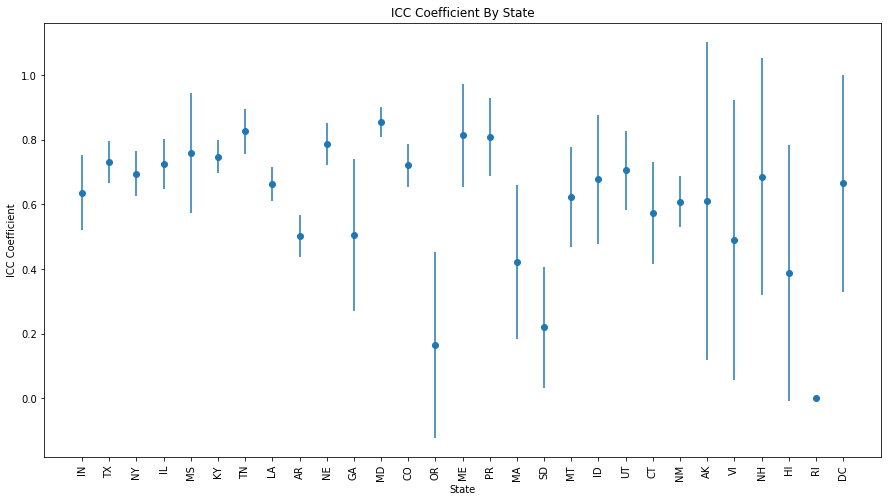

In [24]:
plt.errorbar(np.arange(len(result_by_state_df_grouped.index)), result_by_state_df_grouped['icc_mean'], yerr=result_by_state_df_grouped['icc_std'], ls='None', marker='o')
ax = plt.gca()
ax.xaxis.set_ticks(np.arange(len(result_by_state_df_grouped.index)))
ax.xaxis.set_ticklabels(result_by_state_df_grouped.index, rotation=90)
ax.set_title('ICC Coefficient By State')
plt.xlabel("State")
plt.ylabel("ICC Coefficient")

plt.show()